<a href="https://www.kaggle.com/code/priyanagda/deep-learning-for-re-identification?scriptVersionId=109559681" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

**Paper Implementation: [An Improved Deep Learning Architecture for Person Re-Identification](https://openaccess.thecvf.com/content_cvpr_2015/papers/Ahmed_An_Improved_Deep_2015_CVPR_paper.pdf)**

This paper proposes a deep neural network architecture that formulates the problem of person re-identification
as binary classification. Given an input pair of images, the
task is to determine whether or not the two images represent the same person. 

The network consists of the following distinct layers: two layers of tied convolution with max pooling, cross-input neighborhood differences, patch summary features, across-patch
features, higher-order relationships, and finally a softmax
function to yield the final estimate of whether the input images are of the same person or not.

In [370]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import cv2
import torch.nn.functional as F
from PIL import Image
from glob import glob
from tqdm import tqdm
from itertools import combinations
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

In [371]:
train_images_path = "../input/cuhk03/archive/images_labeled/"

In [372]:
IMAGE_WIDTH = 60
IMAGE_HEIGHT = 160
size = (IMAGE_HEIGHT, IMAGE_WIDTH)

In [373]:
class CustomDataset(Dataset):
    def __init__(self, data, path, transform=None):
        self.data = data
        self.path = path
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img1 = Image.open(train_images_path + self.data["image1"][idx])
        img2 = Image.open(train_images_path + self.data["image2"][idx])
        label = self.data["label"][idx]
        
        # Apply image transformations
        if self.transform is not None:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
        
        return img1, img2, label

In [374]:
train_data = pd.read_csv("../input/cuhk03/pairs.csv")
resize = transform=transforms.Compose([transforms.Resize(size),
                                       transforms.ToTensor()
                                     ])
train_dataset = CustomDataset(train_data, train_images_path, transform=resize)

In [375]:
def visualize_pair(img1, img2, label):
    fig, axes = plt.subplots(1,2)
    axes[0].imshow(np.transpose(img1.numpy(), (1, 2, 0)))
    axes[1].imshow(np.transpose(img2.numpy(), (1, 2, 0)))
    if label:
        fig.suptitle('Same', y=1)
    else:
        fig.suptitle('Different', y=1)

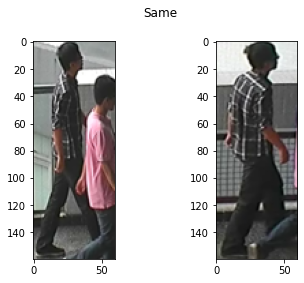

In [376]:
img1, img2, label = train_dataset[100]
visualize_pair(img1, img2, label)

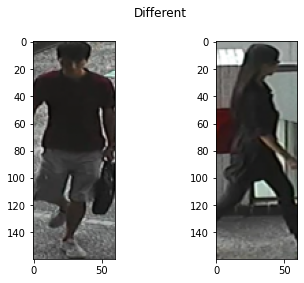

In [377]:
img1, img2, label = train_dataset[50000]
visualize_pair(img1, img2, label)

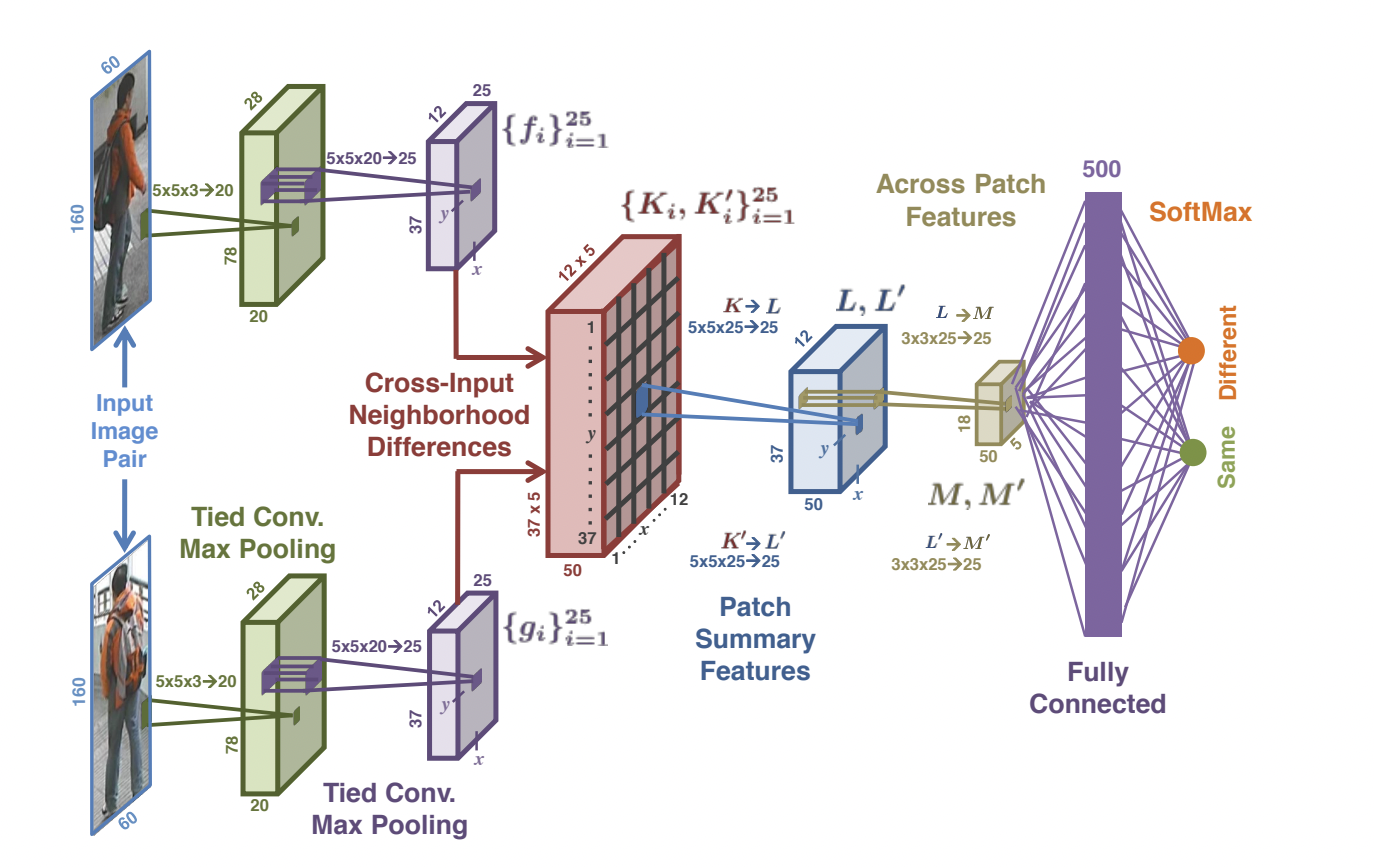

In [392]:
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
    
        self.tied_convolution = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=20, kernel_size=5,stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(in_channels=20, out_channels=25, kernel_size=5, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.patch = nn.Sequential(
            nn.Conv2d(in_channels=25, out_channels=25, kernel_size=5, stride=5),
            nn.ReLU(inplace=True)
        )
        
        self.across_patch = nn.Sequential(
            nn.Conv2d(in_channels=25, out_channels=25, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.relu = nn.ReLU()
        
        self.fc = nn.Sequential(
            
            nn.Linear(4500, 500),
            nn.ReLU(inplace=True),
            
            nn.Linear(500,2)
        )
        
        self.pad = nn.ZeroPad2d(2)
        
        self.softmax = nn.Softmax()
       
    def get_f(self, f):
        _, _, h, w = f.size()
        f = nn.functional.interpolate(f, mode='nearest', size=(h * 5, w * 5))
        f = torch.squeeze(f)
        return f
    
    def get_g(self, y):
        b, c, h, w = y.size()
        g = torch.zeros((b, c, h * 5, w * 5))
        y = self.pad(y)
        for i in range(h):
            for j in range(w):
                a = i*5
                b = j*5
                g[:,:,a:a+5, b:b+5] = y[:,:,i:i+5,j:j+5]
        return g
         
    def cross_input_neighbourhood_difference(self, y1, y2):
        f = self.get_f(y1)
        g = self.get_g(y2)
        return self.relu(f - g)
        
    def forward(self, img1, img2):
        y1 = torch.tensor(img1).float()
        y2 = torch.tensor(img2).float()
        
        y1 = torch.squeeze(y1)
        y2 = torch.squeeze(y2)
        
        y1 = self.tied_convolution(y1)
        y2 = self.tied_convolution(y2)
        
        y1_2 = self.cross_input_neighbourhood_difference(y1, y2)
        y2_1 = self.cross_input_neighbourhood_difference(y2, y1)
    
        y1 = self.patch(y1_2)
        y1 = self.across_patch(y1)
        y2 = self.patch(y2_1)
        y2 = self.across_patch(y2)
        
        y = torch.hstack((y1, y2))
        
        b = y.shape[0]
        y = y.reshape( (b, -1))
        y = self.fc(y)
        
        y = self.softmax(y)
        
        return y

In [393]:
model = DNN()
if torch.cuda.is_available():
    model = model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.01, eps=1e-4, weight_decay=0.0005, momentum=0.9)
epochs = 2
# Batch size 128 leads to ram overflow
batch_size = 32

In [394]:
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)

In [398]:
counter = []
loss_history = [] 
def train():
    iteration_number= 0
    
    for epoch in range(epochs):
        for i, data in enumerate(train_dataloader, 0):
            img1, img2 , label = data
            
            optimizer.zero_grad()
            y = model(img1, img2)
            loss_contrastive = criterion(y, label)
            loss_contrastive.backward()
            optimizer.step()
            
            if i % 50 == 0:
                print("Epoch number {}\n Current loss {}\n".format(epoch, loss_contrastive.item()))
                iteration_number += 10
                counter.append(iteration_number)
                loss_history.append(loss_contrastive.item())

In [ ]:
train()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch number 0
 Current loss 0.7820116877555847

